In [2]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import initializers


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from skbio.stats.distance import mantel
from os import listdir
import seaborn as sns
from scipy.spatial.distance import squareform


In [3]:
def getWeightDir(omic, dim, metric):
    #Name file
    weight_dir = "../weights/autoencoder/" + omic + "/" + metric + "/" + str(dim) + "dim/"
    return(weight_dir)

def getFileName(weight_dir, dim):
    best_val_scores = []
    weight_dir_tmp = weight_dir + dim + "dim/"
    weight_files = listdir(weight_dir_tmp)

    #pick best val score in that folder
    val_scores = [float(i.split('val')[1][0:5]) for i in weight_files]
    best_val_score = np.min(val_scores)
    file_name = weight_files[np.argmin(val_scores)]
    return(weight_dir_tmp + file_name)

def lamb(y):
    return(K.sum(K.square(y), axis = 1) / K.square(K.sum(y, axis = 1)))

def hornLoss(y_true, y_pred):
    print("Y shape" + str(y_true.shape))
    return(1 - 2*K.dot(y_true, K.transpose(y_pred)) / ((lamb(y_true) + lamb(y_pred)) *K.sum(y_true, axis = 1) * K.sum(y_pred, axis = 1)))

def getModel(file_name, metric):
    model = load_model(file_name, compile = False)
    if metric == "euclidean":
        model.compile(loss = 'mean_squared_logarithmic_error')
    if metric == "braycurtis":
        model.compile(loss = brayCurtisLoss)
    if metric == "manhattan":
        model.compile(loss = 'mean_absolute_error')
    if metric == "horn":
        model.compile(loss = hornLoss)
    return(model)


def brayCurtisLoss(y_true, y_pred):
    return(K.abs(K.sum(y_true - y_pred)) / K.sum(y_true + y_pred))

In [4]:
def lambdaDistance(x):
    return(np.sum(np.square(x)) / np.square(np.sum(x)))

def lamb_morisita(y):
    loss = np.dot(y, (np.transpose(y)-1)) / ( np.sum(y)* (np.sum(y)- 1) )
    #print(loss)
    return(loss)

def hornDistance(x, y):
    return(1 - 2 * np.dot(x , y) / ((lambdaDistance(x) + lambdaDistance(y)) * np.sum(x) * np.sum(y)))

def morisitaDistance(x, y):
    return(1 - 2 * np.dot(x , y) / ((lamb_morisita(x) + lamb_morisita(y)) * np.sum(x) * np.sum(y)))
    
%run functions.py
def getPerformance(x_val, omic):
    mantel_corrs = []
    metrics = []
    dims = []
    for metric in ['euclidean','horn', 'manhattan', 'braycurtis']:
        for dim in ['25', '50', '100', '200', '500']:
            #print(metric)
            #print(dim)
            weight_dir =  "../weights/autoencoder/" + omic + "/" + metric + "/"
            file_name = getFileName(weight_dir, dim)
            encoded = encode(x_val, file_name)
            dists_base = squareform(pdist(np.array(x_val), metric = hornDistance))
            dists_encoded = squareform(pdist(encoded, metric = hornDistance))
            mantel_corrs = mantel_corrs + [mantel(dists_base, dists_encoded)[0]]
            metrics = metrics + [metric]
            dims = dims + [dim]
    return(pd.DataFrame({"metrics" : metrics, "dims":dims, "mantel": mantel_corrs}))

In [8]:
omic = "16s/"
x_train = pd.read_csv('../data/' + omic + 'x_train.csv', index_col = 0)
x_val = pd.read_csv('../data/' + omic + 'x_val.csv', index_col = 0)
x_test = pd.read_csv('../data/' + omic + 'x_test.csv', index_col = 0)
perf_16s = getPerformance(x_test, omic = "s")

In [9]:
omic = "mtg/"
x_train = pd.read_csv('../data/' + omic + 'x_train.csv', index_col = 0)
x_val = pd.read_csv('../data/' + omic + 'x_val.csv', index_col = 0)
x_test = pd.read_csv('../data/' + omic + 'x_test.csv', index_col = 0)
perf_mtg = getPerformance(x_test, omic)

In [12]:
omic = "mtt/"
x_train = pd.read_csv('../data/' + omic + 'x_train.csv', index_col = 0)
x_val = pd.read_csv('../data/' + omic + 'x_val.csv', index_col = 0)
x_test = pd.read_csv('../data/' + omic + 'x_test.csv', index_col = 0)
perf_mtt = getPerformance(x_test, omic)

In [11]:
omic = "metabol/"
x_train = pd.read_csv('../data/' + omic + 'x_train.csv', index_col = 0)
x_val = pd.read_csv('../data/' + omic + 'x_val.csv', index_col = 0)
x_test = pd.read_csv('../data/' + omic + 'x_test.csv', index_col = 0)
perf_metabol = getPerformance(x_test, omic)

In [15]:
perf_16s.dims = [int(i) for i in perf_16s.dims]

In [32]:
perf_16s.dims = [int(i) for i in perf_16s.dims]
labels = ['25', '50', '100', '200', '500', , '1000', '2000']
sns.lineplot(x = 'dims', y = 'mantel', hue = 'metrics', data = perf_16s, markers = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '16')

SyntaxError: invalid syntax (<ipython-input-32-8fcbb21b4333>, line 2)

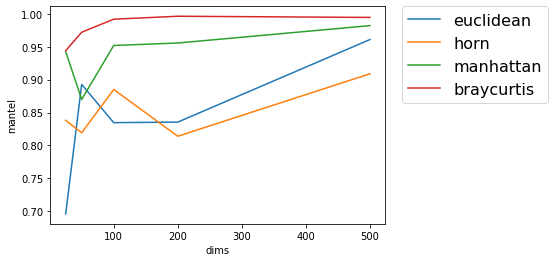

In [31]:
perf_mtg.dims = [int(i) for i in perf_mtg.dims]
labels = [ '25', '50', '100', '200', '500', '1000', '2000']
sns.lineplot(x = 'dims', y = 'mantel', hue = 'metrics', data = perf_mtg, markers = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '16')

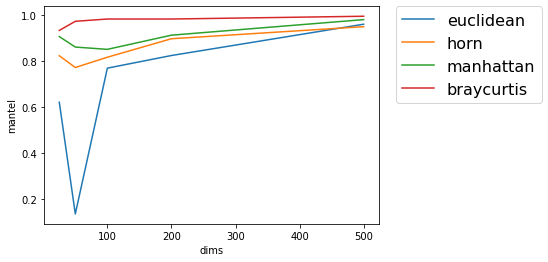

In [30]:
perf_mtt.dims = [int(i) for i in perf_mtt.dims]

labels = [ '25', '50', '100', '200', '500', '1000', '2000']
sns.lineplot(x = 'dims', y = 'mantel', hue = 'metrics', data = perf_mtt, markers = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '16')

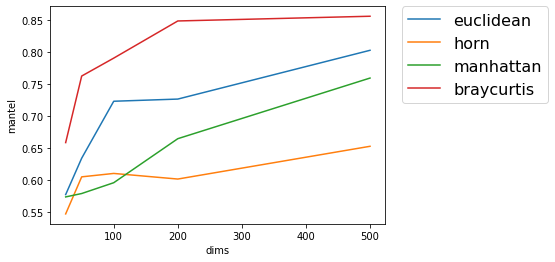

In [29]:
perf_metabol.dims = [int(i) for i in perf_metabol.dims]

labels = [ '25', '50', '100', '200', '500', '1000', '2000']
sns.lineplot(x = 'dims', y = 'mantel', hue = 'metrics', data = perf_metabol, markers = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '16')

In [17]:
def plotCorrs(corrs_base, corrs_encoded):
    fig = plt.figure(figsize=(15, 4))
    axarr = fig.subplots(1,2)
    p = axarr[0].matshow(corrs_base)
    p2 = axarr[1].matshow(corrs_encoded)
    print(corrs_base.shape)
    print(corrs_encoded.shape)
    print(mantel(corrs_base, corrs_encoded))
    fig.colorbar(p)
    fig.colorbar(p2)
    #Print mantel test metric

In [21]:
def plotHeatmaps(omic, encoding_metric, dim, dist_metric):
    weight_dir =  "../weights/autoencoder/" + omic + "/" + encoding_metric + "/"
    file_name = getFileName(weight_dir, dim)

    x_train = pd.read_csv('../data/' + omic +'/'+ 'x_train.csv', index_col = 0)
    x_val = pd.read_csv('../data/' + omic + '/'+ 'x_val.csv', index_col = 0)
    x_test = pd.read_csv('../data/' + omic + '/'+ 'x_test.csv', index_col = 0)
    
    
    for x in [x_train, x_val, x_test]:
        
        encoded = encode(x, file_name)
        dists_base = squareform(pdist(np.array(x), metric = dist_metric))
        dists_encoded = squareform(pdist(encoded, metric = dist_metric))
        if "metabol" in omic:
            outliers = np.mean(dists_base, axis = 1) > (np.median(np.mean(dists_base, axis = 1)) + 2*np.std(np.mean(dists_base, axis = 1)))
            dists_base = dists_base[[not i for i in outliers], :]
            dists_base = dists_base[:, [not i for i in outliers]]
            
            #outliers = np.mean(dists_encoded, axis = 1) > (np.median(np.mean(dists_encoded, axis = 1)) + 2*np.std(np.mean(dists_encoded, axis = 1)))
            dists_encoded = dists_encoded[[not i for i in outliers], :]
            dists_encoded = dists_encoded[:, [not i for i in outliers]]

        plotCorrs(dists_base, dists_encoded)



In [19]:
dists_base = squareform(pdist(np.array(x), metric = 'euclidean'))
outliers = np.mean(dists_base, axis = 1) > (np.median(np.mean(dists_base, axis = 1)) + 2*np.std(np.mean(dists_base, axis = 1)))
dists_base = dists_base[[not i for i in outliers], :]
dists_base[:, [not i for i in outliers]].shape

NameError: name 'x' is not defined

(267, 267)
(267, 267)
(0.8623001984286706, 0.001, 267)
(96, 96)
(96, 96)
(0.8918475782979287, 0.001, 96)
(87, 87)
(87, 87)
(0.9258019137618758, 0.001, 87)


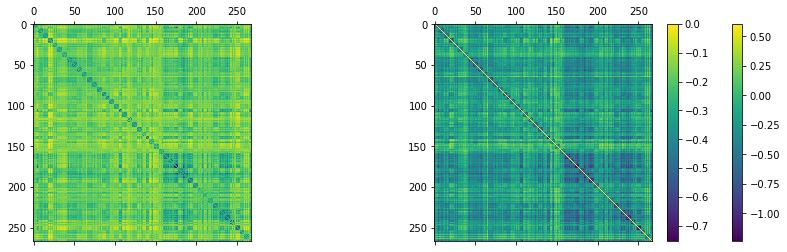

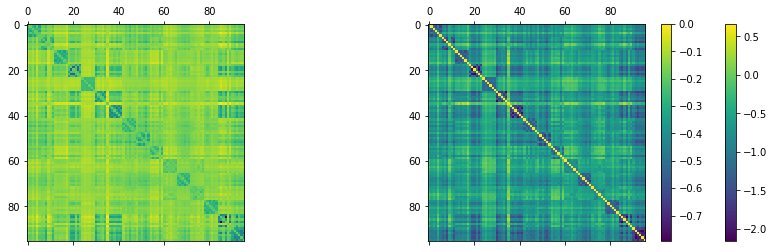

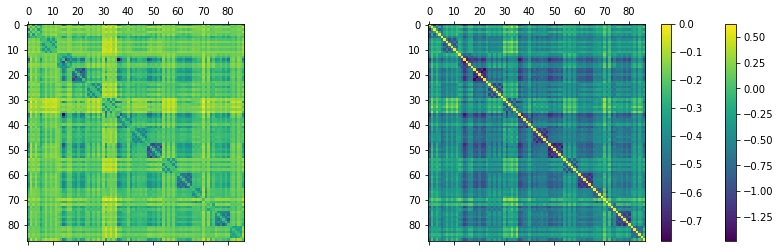

In [24]:
plotHeatmaps("16s/", encoding_metric = "braycurtis", dim = "500", dist_metric = morisitaDistance)

(116, 116)
(116, 116)
(0.9798157624689061, 0.001, 116)
(39, 39)
(39, 39)
(0.9908386913850072, 0.001, 39)
(38, 38)
(38, 38)
(0.9902012392127506, 0.001, 38)


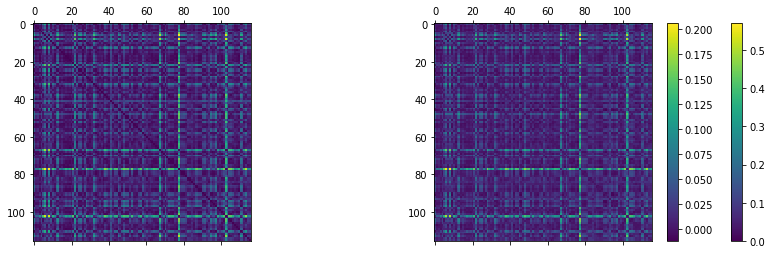

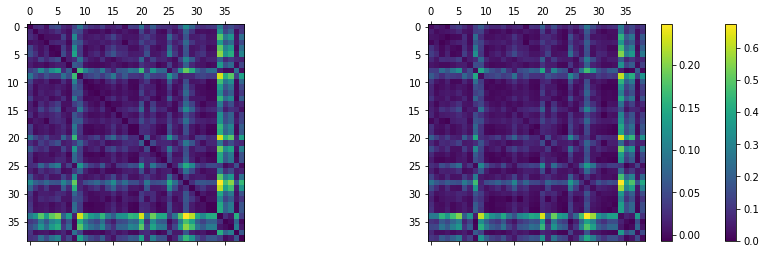

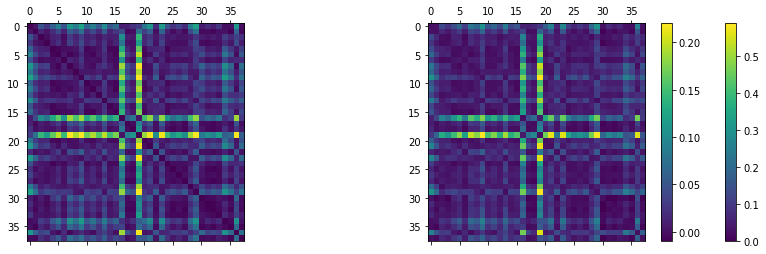

In [25]:
plotHeatmaps("mtg/", encoding_metric ="braycurtis", dim = "100", dist_metric = morisitaDistance)

(112, 112)
(112, 112)
(0.9744316839975243, 0.001, 112)
(39, 39)
(39, 39)
(0.9741459640598016, 0.001, 39)
(37, 37)
(37, 37)
(0.9630277082407713, 0.001, 37)


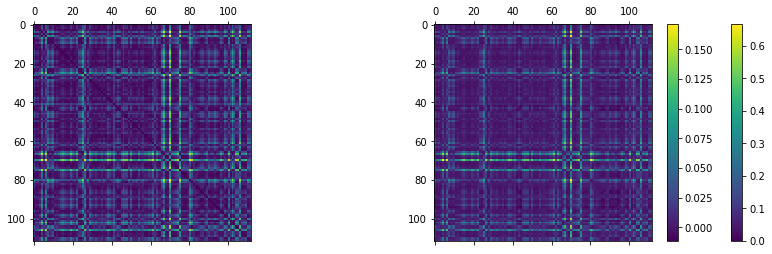

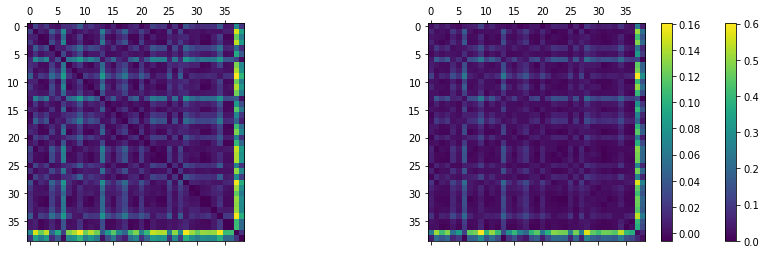

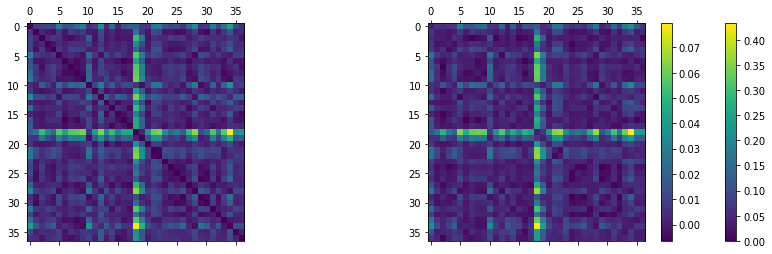

In [26]:
plotHeatmaps("mtt/", encoding_metric ="braycurtis", dim = "50", dist_metric = morisitaDistance)

(100, 100)
(100, 100)
(0.9928752203541006, 0.001, 100)
(34, 34)
(34, 34)
(0.9916591257844296, 0.001, 34)
(35, 35)
(35, 35)
(0.9931700484257975, 0.001, 35)


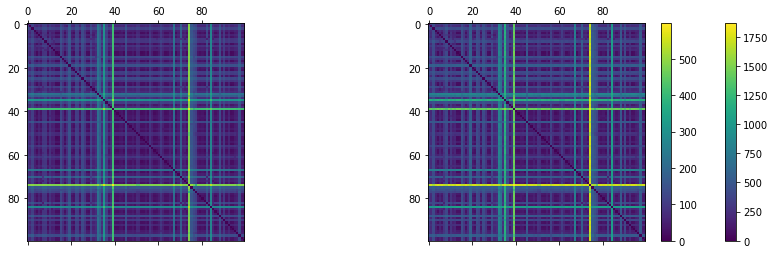

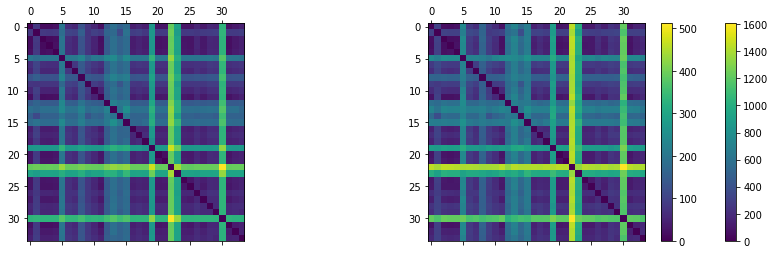

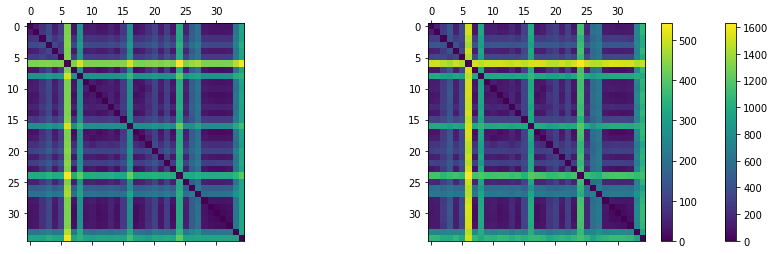

In [27]:
plotHeatmaps("metabol/", "braycurtis", "200", dist_metric = "euclidean")